In [1]:
import numpy as np
import os
import matplotlib as mpl
mpl.use("nbagg")
import matplotlib.pyplot as plt
import re

In [2]:
import scipy.optimize

In [3]:
import copy

In [4]:
from numpy.linalg import LinAlgError

In [5]:
# generate a random function from the prior
r0 = np.linspace(0,1,15)
s0 = 0.1
d0 = 1

In [6]:
#w = np.random.randn(len(r0))*d0
# This is a good set
w = np.array([ 0.98747928, -1.10723434, -0.48583089,  0.08486259,  0.80652947,
        1.18502972,  1.16972347, -0.27499131, -1.16098866,  0.17761498,
       -0.94362564,  0.0403427 , -0.44163086, -0.14625327,  0.3840465 ])

In [7]:
r = np.linspace(0,1,1000)
f = np.dot(np.exp(-0.5*np.subtract.outer(r,r0)**2/s0**2),w)
df = np.dot(-np.subtract.outer(r,r0)*np.exp(-0.5*np.subtract.outer(r,r0)**2/s0**2)/s0**2,w)

<IPython.core.display.Javascript object>


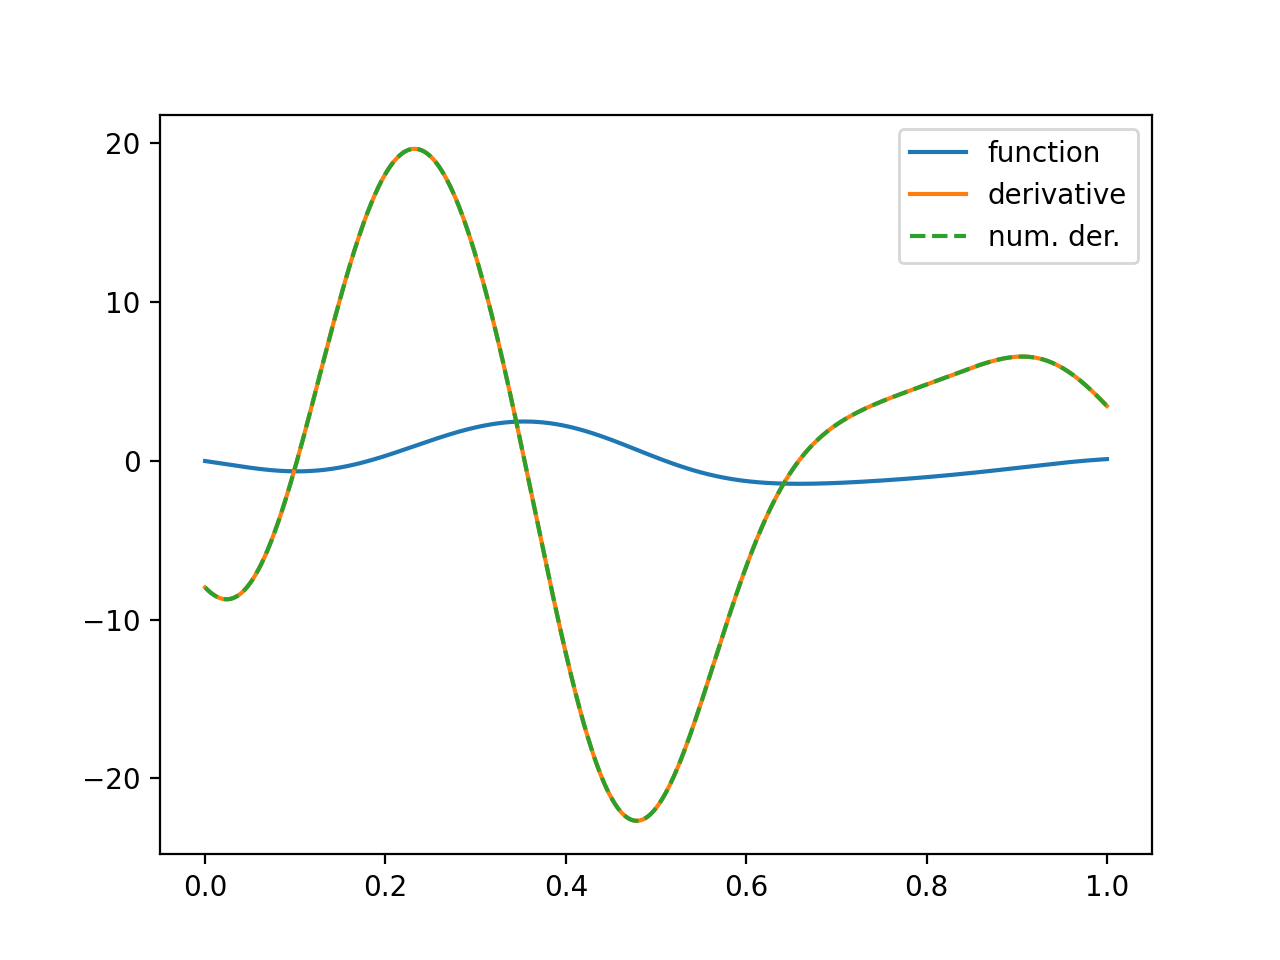

In [8]:
plt.plot(r,f,label="function")
plt.plot(r,df,label="derivative")
plt.plot(r,np.gradient(f,r),"--",label="num. der.")
plt.legend()
plt.show()

In [9]:
# Sample the function

n_sample = 9

# r_sample = np.random.rand(n_sample)
# r_sample[0] = 0
# r_sample[-1] = 1

#r_sample = np.linspace(0,1,n_sample,endpoint=True)
#r_sample = np.array([0.0,0.05,0.10,0.2,0.5,0.65,0.75,0.87,1.0])

r_sample = np.array([0.05,0.18,0.53,0.59,0.65,0.75,0.88,0.95])
n_sample = len(r_sample)
f_sample = np.dot(np.exp(-0.5*np.subtract.outer(r_sample,r0)**2/s0**2),w)
df_sample = np.dot(-np.subtract.outer(r_sample,r0)*np.exp(-0.5*np.subtract.outer(r_sample,r0)**2/s0**2)/s0**2,w)

f_error = 0.00
df_error = 0.00
f_sample += np.random.randn(len(f_sample))*f_error
df_sample += np.random.randn(len(df_sample))*df_error

In [10]:
class GP:
    def __init__(self,sigma,error,function=None,derivative=None,sparse=None):
        if function is not None:
            self.set_function(function)
        else:
            self.r = None
            self.f = np.empty((0))
        if derivative is not None:
            self.set_derivative(derivative)
        else:
            self.dr = None
            self.df = np.empty((0))
        if sparse is not None:
            self.set_sparse(sparse)
        else:
            self.sparse = None
        self.sigma = sigma
        self.error = error
        self.alpha = None
        self.do_sparse = False
        self.do_full = False
            
    def set_function(self,function):
        self.r = function[0]
        self.f = function[1]
    def set_derivative(self,derivative):
        self.dr = derivative[0]
        self.df = derivative[1]
    def set_sparse(self,sparse):
        self.sparse = sparse

    def set_sigma(self,sigma):
        self.sigma = sigma
        
    def set_error(self,error):
        self.error = error
        
    def fit_full(self):

        if self.r is not None:
            self.C = np.exp(-0.5*np.subtract.outer(self.r,self.r)**2/self.sigma**2)
        else:
            self.C = np.empty((0,0))
            
        if (self.r is not None) and (self.dr is not None):
            C = np.exp(-0.5*np.subtract.outer(self.r,self.dr)**2/self.sigma**2)
            self.dC = np.subtract.outer(self.r,self.dr)*C/self.sigma**2
        else:
            self.dC = np.empty((len(self.f),len(self.df)))
            
        if self.dr is not None:
            C = np.exp(-0.5*np.subtract.outer(self.dr,self.dr)**2/self.sigma**2)
            self.ddC = C*(1/self.sigma**2-np.subtract.outer(self.dr,self.dr)**2/self.sigma**4)
        else:
            self.ddC = np.empty((0,0))
        
        self.CC = np.block([[self.C,self.dC],[self.dC.T,self.ddC]])
        self.lam = np.diag([self.error[0]**2]*len(self.f)+[self.error[1]**2]*len(self.df))
        self.target = np.block([self.f,self.df])            
        self.alpha = np.linalg.solve(self.CC+self.lam,self.target)
        self.C_inv = np.linalg.inv(self.CC+self.lam)
        
        self.do_full = True
        self.do_sparse = False
    
    def fit_sparse(self):
        if self.r is not None:
            self.sC = np.exp(-0.5*np.subtract.outer(self.sparse,self.r)**2/self.sigma**2)
        else:
            self.sC = np.empty((len(self.sparse),0))
            
        if self.dr is not None:
            C = np.exp(-0.5*np.subtract.outer(self.sparse,self.dr)**2/self.sigma**2)
            self.dsC = np.subtract.outer(self.sparse,self.dr)*C/self.sigma**2
        else:
            self.dsC = np.empty((len(self.sparse),0))
        
        self.C = np.exp(-0.5*np.subtract.outer(self.sparse,self.sparse)**2/self.sigma**2)
        self.C += np.eye(len(self.sparse))*1e-9
        self.target = np.block([self.f,self.df])
        
        self.lam = np.diag([self.error[0]**2]*len(self.f)+[self.error[1]**2]*len(self.df))
        self.inv_lam = np.diag([1/self.error[0]**2]*len(self.f)+[1/self.error[1]**2]*len(self.df))
        self.sCC = np.block([[self.sC,self.dsC]])
        self.Q = self.C + np.dot(np.dot(self.sCC,self.inv_lam),self.sCC.T)
        try:
            self.alpha = np.linalg.solve(self.Q,np.dot(np.dot(self.sCC,self.inv_lam),self.target))
        except LinAlgError:
            self.alpha = np.inf*np.ones_like(self.target)
        
        try:
            self.C_inv = np.linalg.inv(self.C) - np.linalg.inv(self.Q)
        except LinAlgError:
            self.C_inv = np.inf*np.ones_like(self.C)
            
        self.do_full = False
        self.do_sparse = True
    
    def get_k(self,r):
        if self.do_full:
            if self.r is not None:
                k = np.exp(-0.5*np.subtract.outer(r,self.r)**2/self.sigma**2)
            else:
                k = np.empty((len(r),0))
            if self.dr is not None:
                dk = np.subtract.outer(r,self.dr)*np.exp(
                    -0.5*np.subtract.outer(r,self.dr)**2/self.sigma**2)/self.sigma**2
            else:
                dk = np.empty((len(r),0))
            return np.block([k,dk])
        if self.do_sparse:
            k = np.exp(-0.5*np.subtract.outer(r,self.sparse)**2/self.sigma**2)
            return k   
        
    def predict(self,r,variance=False):
        k = self.get_k(r)
        p = np.dot(k,self.alpha)
        if variance:
            v = 1-np.sum(k*np.dot(k,self.C_inv),axis=1)+self.error[0]**2
            return p,v
        else:
            return p
    
    def likelihood(self):
        if self.alpha is None:
            self.fit_full()
            
        s,d = np.linalg.slogdet(self.CC+self.lam)
        return d + np.dot(self.target,self.alpha)

    def likelihood_sparse(self):
        if self.alpha is None:
            self.fit_sparse()
        CC = np.dot(self.sCC.T,np.linalg.solve(self.C,self.sCC)) + self.lam #np.linalg.inv(self.lam)
        if self.alpha[0] == np.inf:
            return 1.0e6
        try:
            alpha = np.linalg.solve(CC,self.target)
            s,d = np.linalg.slogdet(CC)
            if s > 0:
                return d + np.dot(self.target,alpha) + len(self.alpha)*np.log(2*np.pi)
            else:
                return 1.0e6
        except LinAlgError:
            return 1.0e6

    def optimise(self,do_sigma=True,do_error=True,do_sparse=False,gp_type="full"):
        myGP = copy.copy(self)
        error = []
        if self.r is not None:
            error += [self.error[0]]
        if self.dr is not None:
            error += [self.error[1]]
 
        x0 = []
        if do_error:
            x0 += error
        if gp_type=="sparse" and do_sparse:
            #x0 += self.sparse.tolist()
            x0 += np.tan((self.sparse*2-0.5)*np.pi).tolist()
        if do_sigma:
            x0 += [self.sigma]
            
        def my_likelihood(x):
            my_x = x.copy()
            if do_error:
                if self.r is not None and self.dr is not None:
                    error = my_x[0:2]
                    my_x = my_x[2:]
                elif self.r is None and self.dr is not None:
                    error = [self.error[0],my_x[0]]
                    my_x = my_x[1:]
                elif self.r is not None and self.dr is None:
                    error = [my_x[0],self.error[1]]
                    my_x = my_x[1:]
                error = np.max([np.abs(error),np.array([1.0e-5,1e-2])],axis=0)
            if gp_type=="sparse" and do_sparse:
                sparse = (2*np.arctan(my_x[:len(myGP.sparse)])/np.pi+1)/2 
                my_x = my_x[len(myGP.sparse):]
            if do_sigma:
                sigma = my_x[0]
                my_x = my_x[1:]
            if len(my_x) != 0:
                raise ValueError("wrong length of argument passed")
                
            if do_error:
                myGP.set_error(error)
            if gp_type=="sparse" and do_sparse:
                myGP.set_sparse(sparse)
            if do_sigma:
                myGP.set_sigma(sigma)
                
            if gp_type == "full":
                myGP.fit_full()
                return myGP.likelihood()
            elif gp_type == "sparse":
                myGP.fit_sparse()
                return myGP.likelihood_sparse()
            else:
                raise ValueError(gp_type+" is not a valid gp_type argument")
                    
            
        ret = scipy.optimize.minimize(my_likelihood,x0,method="Powell")
        print(ret.message)
        print("ML = {}".format(ret.fun))
        x = np.array(ret.x).flatten()
        if do_error:
            if self.r is not None and self.dr is not None:
                error = x[0:2]
                x = x[2:]
            elif self.r is None and self.dr is not None:
                error = [self.error[0],x[0]]
                x = x[1:]
            elif self.r is not None and self.dr is None:
                error = [x[0],self.error[1]]
                x = x[1:]
            error = np.max([np.abs(error),np.array([1.0e-5,1e-2])],axis=0)
            self.set_error(error)
            print("Error hyper: ",self.error)
        if do_sparse:
            #sparse = x[:len(self.sparse)]
            sparse = (2*np.arctan(x[:len(self.sparse)])/np.pi+1)/2         
            self.set_sparse(sparse)
            x = x[len(self.sparse):]
            print("Sparse points:", sparse)
        if do_sigma:
            try:
                self.set_sigma(ret.x[-1])
            except IndexError:
                self.set_sigma(ret.x)
            print("Length hyper:",self.sigma)
        if gp_type == "full":        
            self.fit_full()
        elif gp_type == "sparse":
            self.fit_sparse()
        return ret.fun     

In [11]:
fg = {"full_f":{},"full_d":{},"full_fd":{},
      "datasparse_f":{},"datasparse_d":{},"datasparse_fd":{},
      "regularsparse_f":{},"regularsparse_d":{},"regularsparse_fd":{},
      "optsparse_f":{},"optsparse_d":{},"optsparse_fd":{}}
vg = copy.deepcopy(fg)
sp_loc = copy.deepcopy(fg)
sg_opt = copy.deepcopy(fg)
kg = copy.deepcopy(fg)

In [12]:
gp = GP(sigma=0.1,error=(1e-6,1e-6),function=(r_sample,f_sample))
gp.fit_full()

sg_all = [0.1] #[0.05, 0.10,0.2]
for sg in sg_all:
    gp.set_sigma(sg)
    gp.optimise(do_sigma=True)
    #gp.optimise(do_error=False,do_sigma=True)
    fg["full_f"][sg],vg["full_f"][sg] = gp.predict(r,variance=True)
    sp_loc["full_f"][sg] = gp.r
    sg_opt["full_f"][sg] = gp.sigma
    kg["full_f"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = -4.30021311145985
Error hyper:  [0.11593882 0.01      ]
Length hyper: 0.169432155784028


In [13]:
gp = GP(sigma=0.1,error=(1e-6,1e-6),derivative=(r_sample,df_sample))
gp.fit_full()


for sg in sg_all:
    gp.set_sigma(sg)
    gp.optimise(do_sigma=True)
    fg["full_d"][sg],vg["full_d"][sg] = gp.predict(r,variance=True)
    sp_loc["full_d"][sg] = gp.dr
    sg_opt["full_d"][sg] = gp.sigma
    kg["full_d"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = 39.79645804904718
Error hyper:  [1.00000000e-05 9.71107577e-01]
Length hyper: 0.1347992665448715


In [14]:
gp = GP(sigma=0.1,error=(1e-3,1.0e-1),function=(r_sample,f_sample),derivative=(r_sample,df_sample))
gp.fit_full()

for sg in sg_all:
    gp.set_sigma(sg)
    #gp.optimise(do_error=False)
    #gp.optimise(do_sigma=False)
    gp.optimise()
    fg["full_fd"][sg],vg["full_fd"][sg] = gp.predict(r,variance=True)
    sp_loc["full_fd"][sg] = gp.r
    sg_opt["full_fd"][sg] = gp.sigma
    kg["full_fd"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = -21.205250605187373
Error hyper:  [1.e-05 1.e-02]
Length hyper: 0.13997846204622216


In [15]:
gp = GP(sigma=0.1,error=(1e-1,1e-0),
        function=(r_sample,f_sample),
        sparse=r_sample)
gp.fit_sparse()

for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=False)
    fg["datasparse_f"][sg],vg["datasparse_f"][sg] = gp.predict(r,variance=True)
    sp_loc["datasparse_f"][sg] = gp.sparse
    sg_opt["datasparse_f"][sg] = gp.sigma
    kg["datasparse_f"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = 10.405497528646585
Error hyper:  [0.09882612 1.        ]
Length hyper: 0.16034542130043017


In [16]:
gp = GP(sigma=0.1,error=(1e-3,2e-5),
        derivative=(r_sample,df_sample),
        sparse=r_sample)
gp.fit_sparse()

for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    gp.optimise(do_error=True,do_sigma=True,gp_type="sparse",do_sparse=False)
    fg["datasparse_d"][sg],vg["datasparse_d"][sg] = gp.predict(r,variance=True)
    fg["datasparse_d"][sg] -= np.mean(fg["datasparse_d"][sg])
    sp_loc["datasparse_d"][sg] = gp.sparse
    sg_opt["datasparse_d"][sg] = gp.sigma
    kg["datasparse_d"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = 57.75274638293745
Error hyper:  [1.00000000e-03 6.53309303e+00]
Length hyper: 0.16595129280863788


In [17]:
gp = GP(sigma=0.1,error=(1e-3,1e-0),
        function=(r_sample,f_sample),
        derivative=(r_sample,df_sample),
        sparse=r_sample)
gp.fit_sparse()

for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=False)
    fg["datasparse_fd"][sg],vg["datasparse_fd"][sg] = gp.predict(r,variance=True)
    sp_loc["datasparse_fd"][sg] = gp.sparse
    sg_opt["datasparse_fd"][sg] = gp.sigma
    kg["datasparse_fd"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = 41.844770719148215
Error hyper:  [0.02065228 3.26544295]
Length hyper: 0.1599612736000643


In [18]:
r_sparse = np.linspace(0.05,0.95,8,endpoint=True)

In [19]:
gp = GP(sigma=0.1,error=(1e-3,1e0),
        function=(r_sample,f_sample),
       sparse=r_sparse)
gp.fit_sparse()

for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    gp.optimise(do_sigma=False,gp_type="sparse",do_sparse=False)
    gp.optimise(do_error=False,do_sigma=True,gp_type="sparse",do_sparse=False)
    fg["regularsparse_f"][sg],vg["regularsparse_f"][sg] = gp.predict(r,variance=True)
    sp_loc["regularsparse_f"][sg] = gp.sparse
    sg_opt["regularsparse_f"][sg] = gp.sigma
    kg["regularsparse_f"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = 5.879720155176312
Error hyper:  [1.e-05 1.e+00]
Optimization terminated successfully.
ML = 5.744774165867305
Length hyper: 0.0985508354260281


In [20]:
gp = GP(sigma=0.1,error=(1e-3,1e-0),
        derivative=(r_sample,df_sample),
       sparse=r_sparse)
gp.fit_sparse()

for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=False)
    fg["regularsparse_d"][sg],vg["regularsparse_d"][sg] = gp.predict(r,variance=True)
    fg["regularsparse_d"][sg] -= np.mean(fg["regularsparse_d"][sg])
    sp_loc["regularsparse_d"][sg] = gp.sparse
    sg_opt["regularsparse_d"][sg] = gp.sigma
    kg["regularsparse_d"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = 51.78957182778665
Error hyper:  [0.001      0.35055512]
Length hyper: 0.13177195406211129


In [21]:
gp = GP(sigma=0.1,error=(1e-3,1e-0),
        function=(r_sample,f_sample),
        derivative=(r_sample,df_sample),
       sparse=r_sparse)
gp.fit_sparse()

for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=False)
    fg["regularsparse_fd"][sg],vg["regularsparse_fd"][sg] = gp.predict(r,variance=True)
    sp_loc["regularsparse_fd"][sg] = gp.sparse
    sg_opt["regularsparse_fd"][sg] = gp.sigma
    kg["regularsparse_fd"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = 12.596059564969561
Error hyper:  [0.0079392  0.32030924]
Length hyper: 0.14904405776831936


In [22]:
#r_opt_sparse = np.array([0.1,0.25,0.4,0.55,0.7,0.85,1.0])
#r_opt_sparse = np.array([0.25,0.4,0.55,0.7,0.85])
r_opt_sparse = np.random.rand(4)

## Optimising sparse point locations as well. Lots of local minima, so repeating the minimisation many times from random locations

In [42]:
gp = GP(sigma=0.1,error=(1e-3,1e-0),
        function=(r_sample,f_sample),
       sparse=r_opt_sparse)
gp.fit_sparse()

r_old_sparse = np.array([0.62522277, 0.04028199, 0.79564153, 0.37959164 ] )
sigma_old_sparse = 0.0763121697006849
error_old_sparse = (1.e-5, 1.e0 )
use_old_sparse = True

if use_old_sparse:
    n_attempts = 0
else:
    n_attempts = 300

if use_old_sparse:
    n_attempts = 1
else:
    n_attempts = 300
    
for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    ml = 1e9
    msparse = r_opt_sparse
    for i in range(n_attempts):
        gp.set_sparse(np.random.rand(np.random.randint(2,10)))
        #gp.set_sparse(np.random.rand(len(r_opt_sparse)))
        gp.set_sigma(0.1)
        gp.set_error((1e-3,1e0))
#         ml_new = gp.optimise(do_sigma=False,gp_type="sparse",do_sparse=True,do_error=False)
#         ml_new = gp.optimise(do_sigma=False,gp_type="sparse",do_sparse=False,do_error=True)
#         ml_new = gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=False,do_error=False)
        ml_new = gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=True,do_error=True)
        if ml_new < ml:
            ml = ml_new
            msparse = gp.sparse*1.0
            merror = copy.copy(gp.error)
            msigma = gp.sigma*1.0
    print("ML: = ",ml,merror,msigma)
    if use_old_sparse:
        msparse = r_old_sparse
        msigma = sigma_old_sparse
        merror = error_old_sparse
        
    gp.set_sparse(msparse)
    gp.set_error(merror)
    gp.set_sigma(msigma)
    gp.fit_sparse()
            
    fg["optsparse_f"][sg],vg["optsparse_f"][sg] = gp.predict(r,variance=True)
    sp_loc["optsparse_f"][sg] = gp.sparse
    sg_opt["optsparse_f"][sg] = gp.sigma
    kg["optsparse_f"][sg] = gp.get_k(r)

Optimization terminated successfully.
ML = -13.164570233917335
Error hyper:  [1.e-05 1.e+00]
Sparse points: [9.99999999e-01 9.99999993e-01 8.29660797e-01 7.21644966e-16
 7.32529866e-07 4.69011663e-01 5.76137410e-01 9.86718523e-01]
Length hyper: 0.10411758210814315
ML: =  -13.164570233917335 [1.e-05 1.e+00] 0.10411758210814315


In [43]:
gp = GP(sigma=0.1,error=(1e-3,1e-0),
        derivative=(r_sample,df_sample),
       sparse=r_opt_sparse)
gp.fit_sparse()

r_old_sparse = np.array([0.6460279,  0.08778179, 1.  ,       0.38969604])
error_old_sparse = ( 0.001,0.01 )
sigma_old_sparse = 0.08411814312701239
use_old_sparse = True

if use_old_sparse:
    n_attempts = 0
else:
    n_attempts = 300

for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    ml = 1e9
    msparse = r_opt_sparse
    for i in range(n_attempts):      
        #gp.set_sparse(np.random.rand(len(r_opt_sparse)))
        gp.set_sparse(np.random.rand(np.random.randint(2,10)))
        gp.set_sigma(0.1)

        gp.set_error((1e-3,1e-1))
#         ml_new = gp.optimise(do_sigma=False,gp_type="sparse",do_sparse=True,do_error=False)
#         ml_new = gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=False,do_error=False)
#         ml_new = gp.optimise(do_sigma=False,gp_type="sparse",do_sparse=False,do_error=True)
        ml_new = gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=True,do_error=True)
        if ml_new < ml:
            ml = ml_new
            msparse = gp.sparse*1.0
            merror = copy.copy(gp.error)
            msigma = gp.sigma*1.0
    print("ML: = ",ml,merror,msigma)
    if use_old_sparse:
        msparse = r_old_sparse
        msigma = sigma_old_sparse
        merror = error_old_sparse
            
    gp.set_sparse(msparse)
    gp.set_error(merror)
    gp.set_sigma(msigma)
    gp.fit_sparse()
    
    fg["optsparse_d"][sg],vg["optsparse_d"][sg] = gp.predict(r,variance=True)
    fg["optsparse_d"][sg] -= fg["optsparse_d"][sg].mean()
    sp_loc["optsparse_d"][sg] = gp.sparse
    sg_opt["optsparse_d"][sg] = gp.sigma
    kg["optsparse_d"][sg] = gp.get_k(r)

ML: =  1000000000.0 (1e-05, 1.0) 0.0763121697006849


In [44]:
gp = GP(sigma=0.1,error=(1e-3,1e0),
        function=(r_sample,f_sample),
        derivative=(r_sample,df_sample),
       sparse=r_opt_sparse)
gp.fit_sparse()

r_old_sparse = np.array([0, 4.84877637e-01, 8.04381716e-01, 4.05657367e-01,
 7.10129013e-02, 1.00000000e+00] )
sigma_old_sparse = 0.13526087646641977
error_old_sparse = (1.00000000e-05, 8.94890326e-02)
use_old_sparse = True

if use_old_sparse:
    n_attempts = 0
else:
    n_attempts = 300
    
for sg in sg_all:
    gp.set_sigma(sg)
    gp.fit_sparse()
    ml = 1e9
    msparse = r_opt_sparse
    for i in range(n_attempts):
        gp.set_sparse(np.random.rand(np.random.randint(2,10)))
        gp.set_sigma(0.1)
        gp.set_error((1e-3,0.1))

#         ml_new = gp.optimise(do_sigma=False,gp_type="sparse",do_sparse=True,do_error=False)
#         ml_new = gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=False,do_error=False)
#         ml_new = gp.optimise(do_sigma=False,gp_type="sparse",do_sparse=False,do_error=True)
        ml_new = gp.optimise(do_sigma=True,gp_type="sparse",do_sparse=True,do_error=True)
        if ml_new < ml:
            ml = ml_new
            msparse = gp.sparse*1.0
            merror = copy.copy(gp.error)
            msigma = gp.sigma*1.0
    print("ML: = ",ml,merror,msigma)
    if use_old_sparse:
        msparse = r_old_sparse
        msigma = sigma_old_sparse
        merror = error_old_sparse
            
    gp.set_sparse(msparse)
    gp.set_error(merror)
    gp.set_sigma(msigma)
    gp.fit_sparse()
    
    fg["optsparse_fd"][sg],vg["optsparse_fd"][sg] = gp.predict(r,variance=True)
    sp_loc["optsparse_fd"][sg] = gp.sparse
    sg_opt["optsparse_fd"][sg] = gp.sigma
    kg["optsparse_fd"][sg] = gp.get_k(r)

ML: =  1000000000.0 (0.001, 0.01) 0.08411814312701239


In [24]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib import patches

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


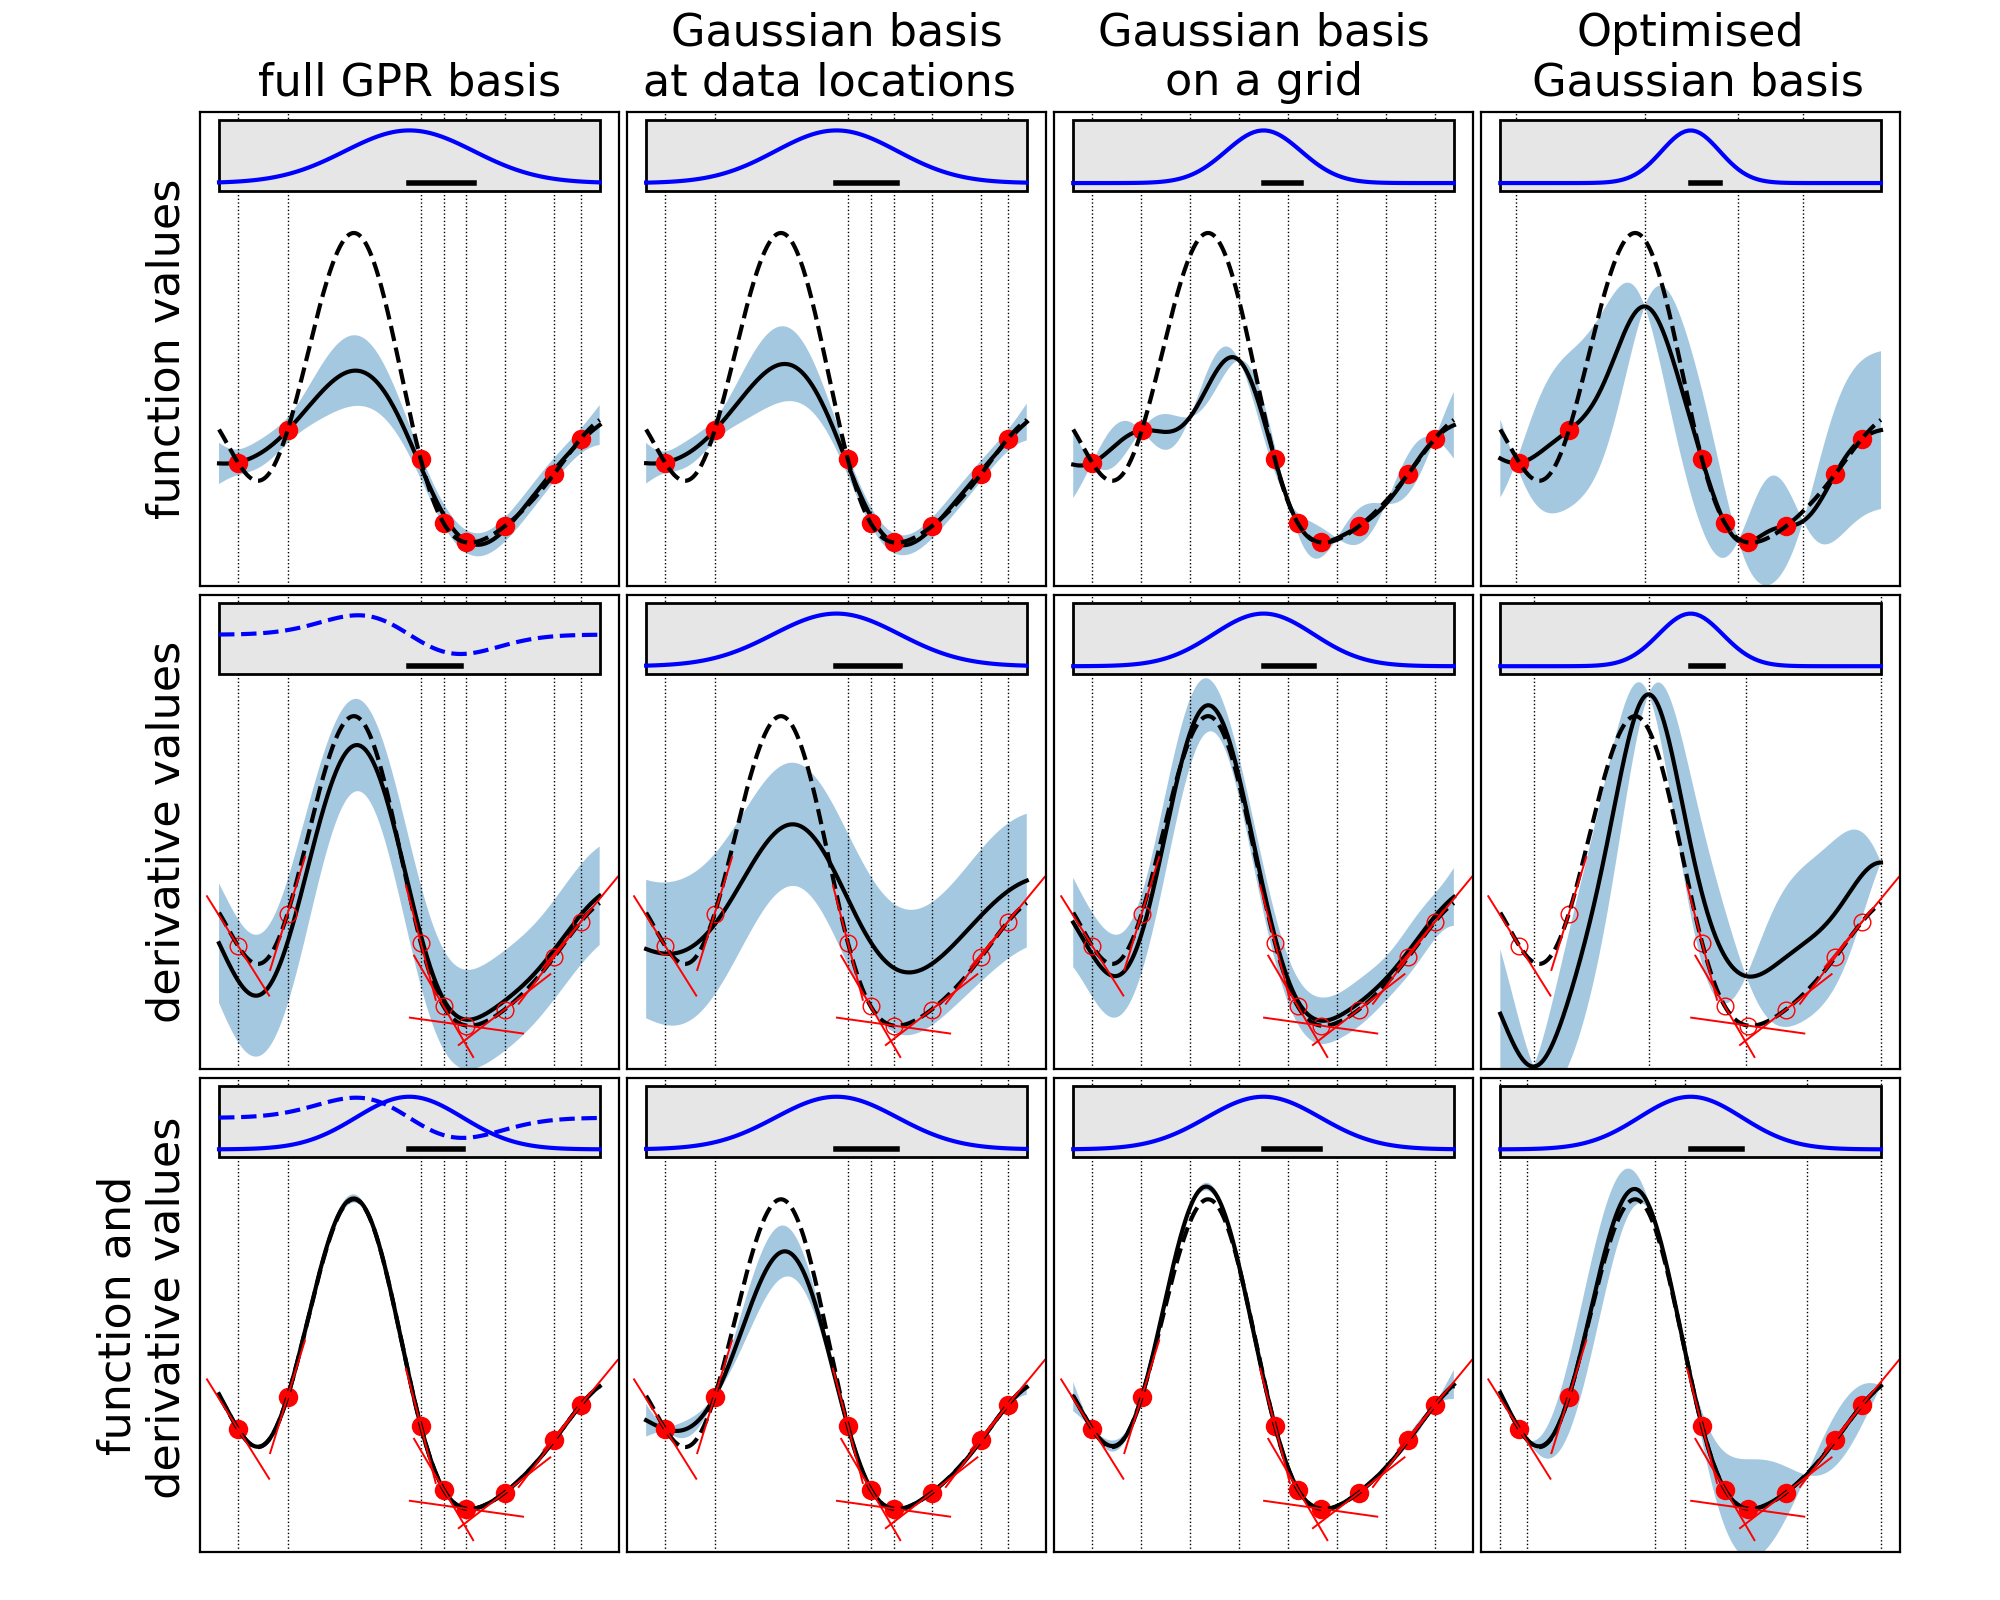

In [126]:
# fig,ax = plt.subplots(4,3,figsize=(8,10),sharex=True,gridspec_kw={"hspace":0.02,"wspace":0.02})
fig,ax = plt.subplots(3,4,figsize=(10,8),sharex=True,gridspec_kw={"hspace":0.02,"wspace":0.02})


fg_key = [["full_f","full_d","full_fd"],
          ["datasparse_f","datasparse_d","datasparse_fd"],
          ["regularsparse_f","regularsparse_d","regularsparse_fd"],
          ["optsparse_f","optsparse_d","optsparse_fd"]]
for i,aa in enumerate(ax):
    for j,a in enumerate(aa):
        for sg in [0.1]: #sg_all:
            #_f0 = fg[fg_key[i][j]][sg]
            #_v = vg[fg_key[i][j]][sg]
            
            _f0 = fg[fg_key[j][i]][sg]
            _v = vg[fg_key[j][i]][sg]
            
            _fp = _f0 + np.sqrt(_v)
            _fm = _f0 - np.sqrt(_v)
            a.fill_between(r,_fm,_fp,label="$l = {:.2f}$".format(sg),alpha=0.4)
            a.plot(r,_f0,"k-",label="$l = {:.2f}$".format(sg))
            
            s = sg_opt[fg_key[j][i]][sg]
            rr = np.linspace(-0.5,0.5,100)
            
            if fg_key[j][i] != 'full_d':
                basis = np.exp(-(rr)**2/(2*s**2))
                a.plot(rr+0.5,basis/1.5+3.1, 'b-', zorder=20)
            
            if re.search("full_[f]*d", fg_key[j][i]):
                basis = -rr*np.exp(-(rr)**2/(2*s**2))
                a.plot(rr+0.5, basis*3+3.5, 'b--', zorder=20)
            
            a.plot([0.5, 0.5+s], [3.1, 3.1], 'k-', linewidth=2, zorder=20)
            
            #for _sp_loc in sp_loc[fg_key[i][j]][sg]:
            for _sp_loc in sp_loc[fg_key[j][i]][sg]:
                a.plot([_sp_loc,_sp_loc],[-2,4.0],"k:",linewidth=0.5)
            #a.plot([-0.05,1.05], [3.0, 3.0], 'k-', linewidth=0.5)
            
                
        if re.search("_d$", fg_key[j][i]):
            a.plot(r_sample,f_sample,'ro',label="data", markerfacecolor='none', markeredgewidth=0.5)    
        else:
            a.plot(r_sample,f_sample,'ro',label="data")
            
            
        
        scalebar = AnchoredSizeBar(a.transData,
                                   sg_opt[fg_key[j][i]][sg], 
                                   r'$\sigma_\mathrm{length}$', 'upper right', 
                           pad=0.5,
                           color='black',
                           frameon=False,
                           size_vertical=0.05)
        #a.add_artist(scalebar)
        
        a.add_artist(patches.Rectangle([0.0, 3.0], 1.0, 0.9, edgecolor='k', zorder=10, facecolor=(0.9,0.9,0.9), fill=True))
        
        a.plot(r,f,"k--",label="original")
        a.set_xlim([-0.05,1.05])
        a.set_ylim([-2,3.5])
        a.set_xticks([])
        a.set_yticks([])
        pr = (1.05-(-0.05))/(3.5-(-2.0))
        sticksize=0.15
        if not re.search("_f$", fg_key[j][i]):
            for ii,s in enumerate(r_sample):
                ddx = sticksize
                ddy = sticksize*df_sample[ii]
                rr = np.sqrt(np.abs(ddx*ddx + ddy*ddy*pr*pr))
                dx = sticksize*ddx/rr
                dy = sticksize*ddy/rr
                #print(df_sample[ii], dx, dy, np.sqrt(dx*dx+dy*dy))
                a.plot([r_sample[ii]-dx, r_sample[ii]+dx],
                       [f_sample[ii]-dy, f_sample[ii]+dy],
                       'r-', linewidth=0.7)

            
#         a.plot(r_sample,f_sample,'ks',label="data")    
#         a.plot(r,f,"k--",label="original")
        
        a.set_xlim([-0.05,1.05])
        a.set_ylim([-2,4])
        a.set_xticks([])
        a.set_yticks([])

# a = ax[0,0]
# a.set_title(u"function values",fontsize=16)
# a = ax[0,1]
# a.set_title(u"derivative values",fontsize=16)
# a = ax[0,2]
# a.set_title(u"function and\n derivative values",fontsize=16)

# a = ax[0,0]
# a.set_ylabel(u"full basis",fontsize=16)
# a = ax[1,0]
# a.set_ylabel(u"Gaussian basis\nat data points ",fontsize=16)
# a = ax[2,0]
# a.set_ylabel(u"Gaussian basis\non a grid",fontsize=16)
# a = ax[3,0]
# a.set_ylabel(u"Gaussian basis at\noptimised locations",fontsize=16)

a = ax[0,0]
a.set_ylabel(u"function values",fontsize=16)
a = ax[1,0]
a.set_ylabel(u"derivative values",fontsize=16)
a = ax[2,0]
a.set_ylabel(u"function and\n derivative values",fontsize=16)

a = ax[0,0]
a.set_title(u"full GPR basis",fontsize=16)
a = ax[0,1]
a.set_title(u"Gaussian basis\nat data locations ",fontsize=16)
a = ax[0,2]
a.set_title(u"Gaussian basis\non a grid",fontsize=16)
a = ax[0,3]
a.set_title(u"Optimised\n Gaussian basis",fontsize=16)


fig.subplots_adjust(bottom=0.03, top=0.93,left=0.10,right=0.95)
fig.savefig("gp_learn.pdf")
fig.show()


<IPython.core.display.Javascript object>


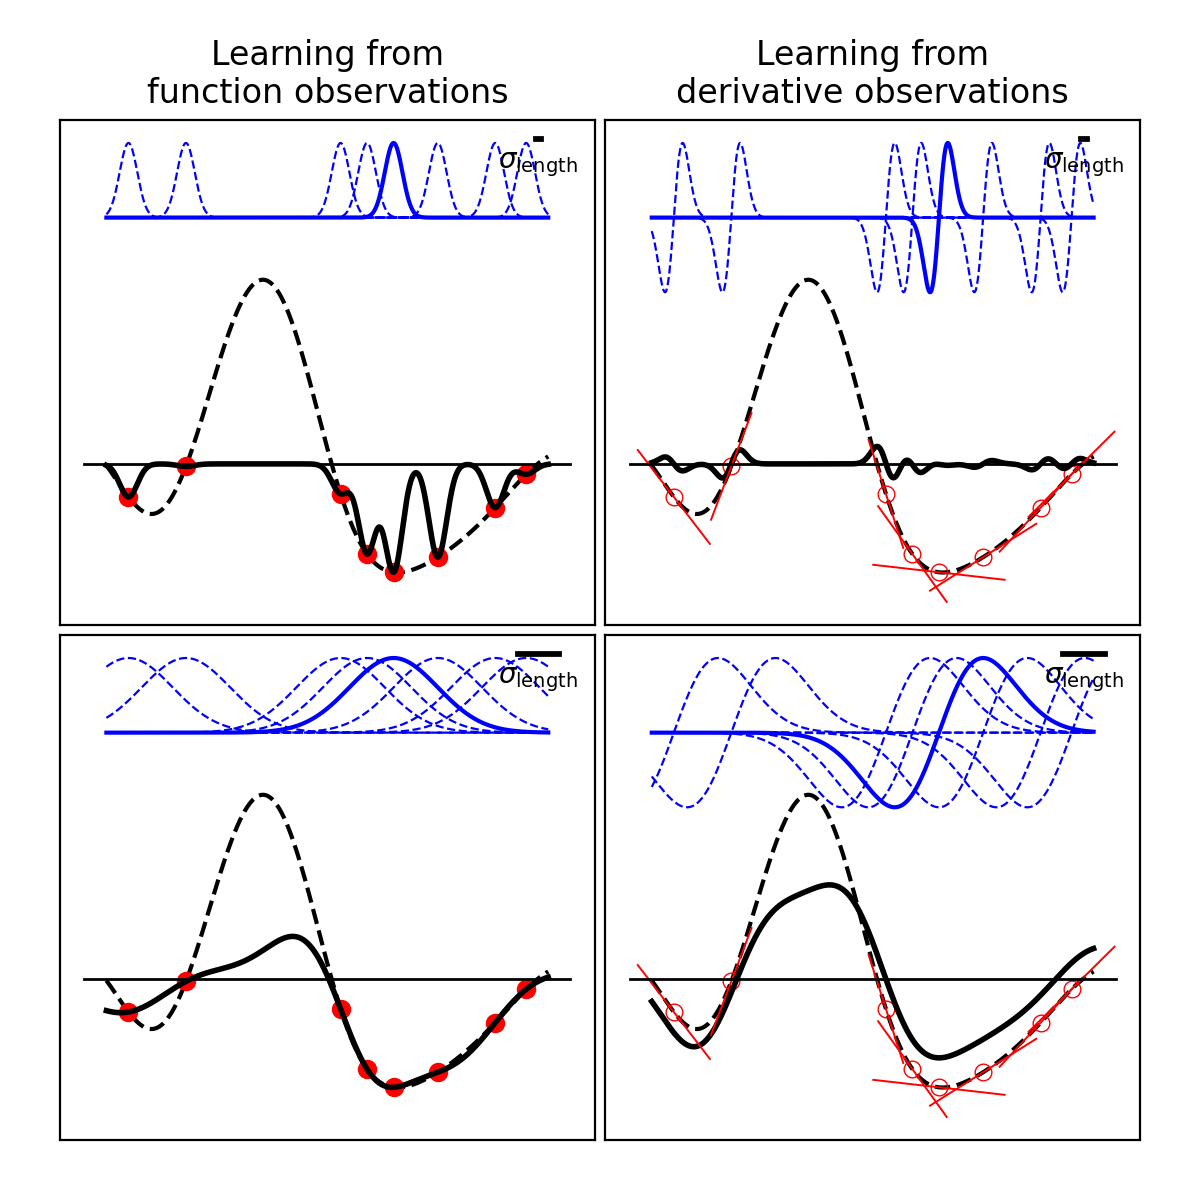

In [38]:
fig,ax = plt.subplots(2,2,figsize=(6,6),sharey=True,gridspec_kw={"hspace":0.02,"wspace":0.02})

for i,sg in enumerate([0.02,0.1]):
    a = ax[i,1]
    gp = GP(sigma=sg,error=(1e-6,3),derivative=(r_sample,df_sample))
    gp.fit_full()
    
    f_gp,v_gp = gp.predict(r,variance=True)
    k = gp.get_k(r)

    
    #for _i,_k in enumerate((k * gp.alpha).T):
    for _i,_k in enumerate(k.T):
        _k_max = np.max([_k.max(),np.abs(_k.min())])
        if _i == 4:
            a.plot(r,3.3+_k/_k_max,"b-",label="basis",linewidth=1.5)
        else:
            a.plot(r,3.3 +_k/_k_max,"b--",linewidth=0.8)
    
    a.plot(r,f,"k--",label="$y(x)$")
    a.plot(r_sample,f_sample,'ro',label=u"$\{x_i,y_i\}$", markerfacecolor='none', markeredgewidth=0.5)
    a.plot(r,f_gp,"k-",label=u"$y_\mathrm{GP}(x)$",linewidth=2.0)
    
    scalebar = AnchoredSizeBar(a.transData,
                               sg, 
                               r'$\sigma_\mathrm{length}$', 'upper right', 
                               pad=0.5,
                               color='black',
                               frameon=False,
                               size_vertical=0.05)

    a.add_artist(scalebar)

    pr = (1.05-(-0.05))/(3.5-(-2.0))
    sticksize=0.15
    for ii,s in enumerate(r_sample):
        ddx = sticksize
        ddy = sticksize*df_sample[ii]
        rr = np.sqrt(np.abs(ddx*ddx + ddy*ddy*pr*pr))
        dx = sticksize*ddx/rr
        dy = sticksize*ddy/rr
        #print(df_sample[ii], dx, dy, np.sqrt(dx*dx+dy*dy))
        a.plot([r_sample[ii]-dx, r_sample[ii]+dx],
                [f_sample[ii]-dy, f_sample[ii]+dy],
                    'r-', linewidth=0.7)

    
    
    
    # x axis
    a.plot([-0.05,1.05], [0,0], "k-", linewidth=1.0)
        
    #a.text(0,-1.5,u"$\sigma_\mathrm{length} = $"+u"${:.2f}$".format(sg),ha="left")
    a.set_xticks([])
    a.set_yticks([])
    
for i,sg in enumerate([0.02,0.1]):
    a = ax[i,0]
    gp = GP(sigma=sg,error=(1e-6,1e-6),function=(r_sample,f_sample))
    gp.fit_full()
    
    f_gp,v_gp = gp.predict(r,variance=True)
    k = gp.get_k(r)
    #for _i,_k in enumerate((k * gp.alpha).T):
    for _i,_k in enumerate(k.T):
        if _i == 4:
            a.plot(r,3.3+_k,"b-",label="basis",linewidth=1.5)
        else:
            a.plot(r,3.3+_k,"b--",linewidth=0.8)

    a.plot(r,f,"k--",label=u"target\nfunction")
    a.plot(r_sample,f_sample,'ro',label=u"datapoints")
    a.plot(r,f_gp,"k-",label=u"GP prediction",linewidth=2.0)
    
    scalebar = AnchoredSizeBar(a.transData,
                               sg, 
                               r'$\sigma_\mathrm{length}$', 'upper right', 
                               pad=0.5,
                               color='black',
                               frameon=False,
                               size_vertical=0.05)
        
    a.add_artist(scalebar)
    
    # x axis
    a.plot([-0.05,1.05], [0,0], "k-", linewidth=1.0)
    
    #a.text(0,-1.5,u"$\sigma_\mathrm{length} = $"+u"${:.2f}$".format(sg),ha="left")
    a.set_xticks([])
    a.set_yticks([])
    

a = ax[0,0]
#a.legend(loc="upper right",frameon=False)
a.set_title("Learning from\nfunction observations")
#a.set_ylim([-1.6,3])
a = ax[0,1]
a.set_title("Learning from\nderivative observations")
fig.subplots_adjust(bottom=0.05, top=0.9,left=0.05,right=0.95)
fig.savefig("gp_basis.pdf")
fig.show()

## Disregard stuff below

In [1246]:
r1 = 0.7
r2 = 1.2
r0 = [0.8,1,1.4]

x = np.array([
    [0.0,0.0],
    [r1,0.0],
    [0,0]
]) 

coefficients = [0.5,0.9,1.4]
e_all = []
a_all = np.linspace(0.0,np.pi,1000,endpoint=True)
for a in a_all:
    x[2] = r2*np.array([np.cos(a),np.sin(a)])
    v = np.sort([np.linalg.norm(x[0]-x[1]),np.linalg.norm(x[0]-x[2]),np.linalg.norm(x[2]-x[1])])
    #print([np.linalg.norm(x[0]-x[1]),np.linalg.norm(x[0]-x[2]),np.linalg.norm(x[2]-x[1])])
    e = np.dot(coefficients,(v-r0)**2)
    e_all.append(e)


/Users/albert/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


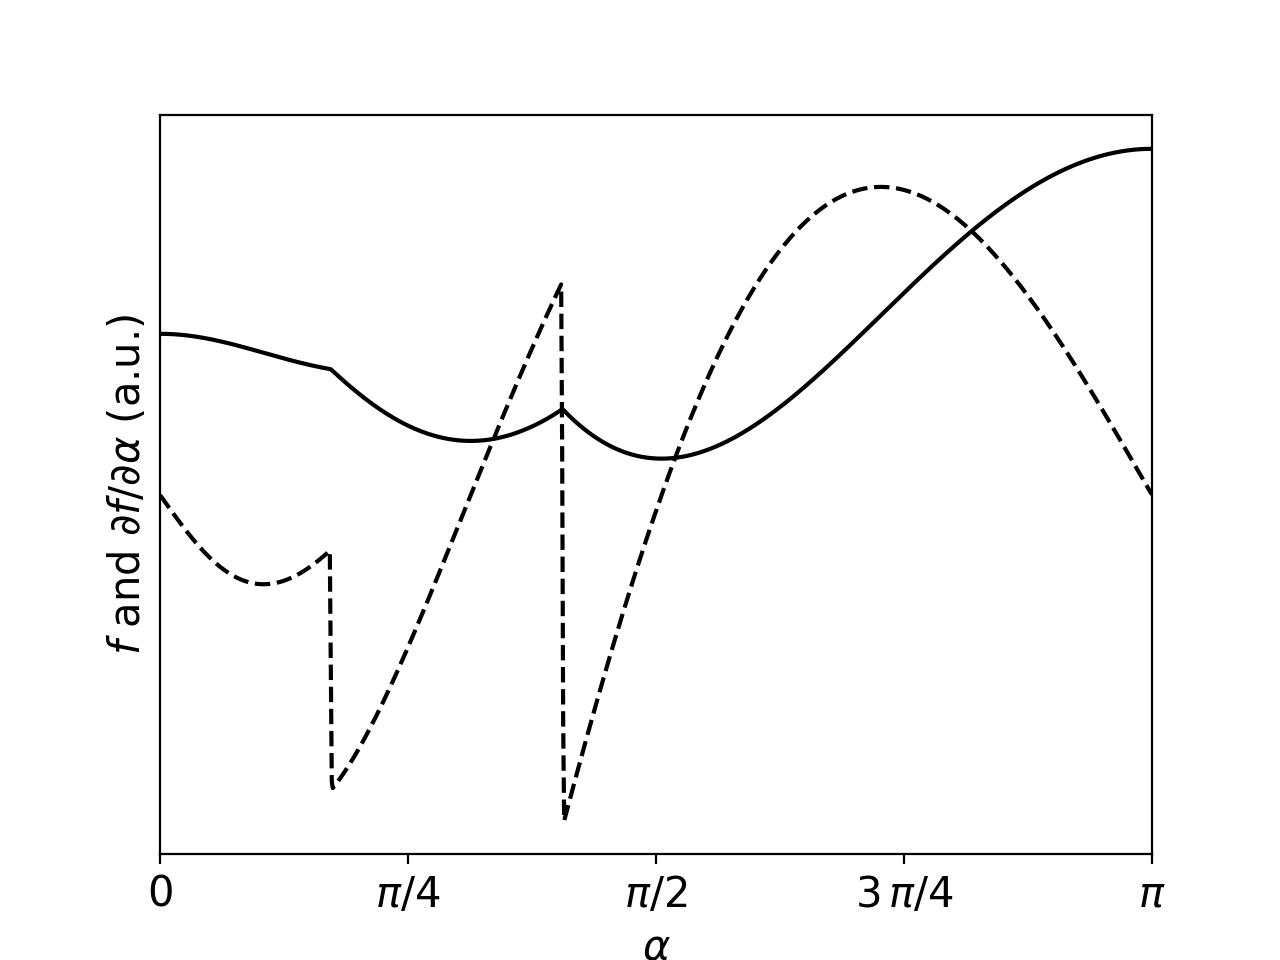

In [1451]:
plt.plot(a_all,e_all,"k")
plt.plot(a_all,np.gradient(e_all,a_all),"k--")
plt.xlim([0,np.pi])
#plt.ylim([0,7])
plt.xticks(np.pi*np.array([0,0.25,0.5,0.75,1]),labels=["0","$\pi$/4","$\pi$/2","$3\,\pi/4$","$\pi$"],fontsize=15)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel(r"$f$ and $\partial f / \partial \alpha$ (a.u.)",fontsize=15)
plt.yticks([])
plt.savefig("ordered_list.svg")
plt.show()

<IPython.core.display.Javascript object>


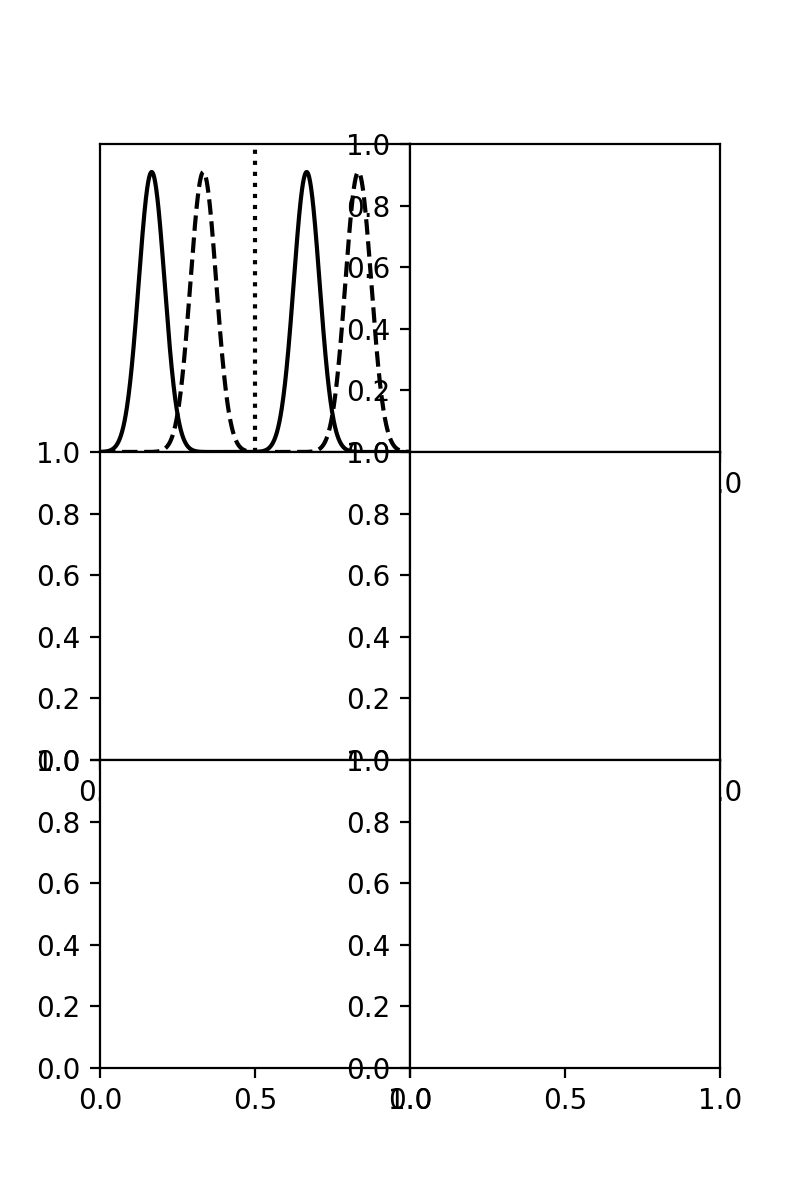

<IPython.core.display.Javascript object>


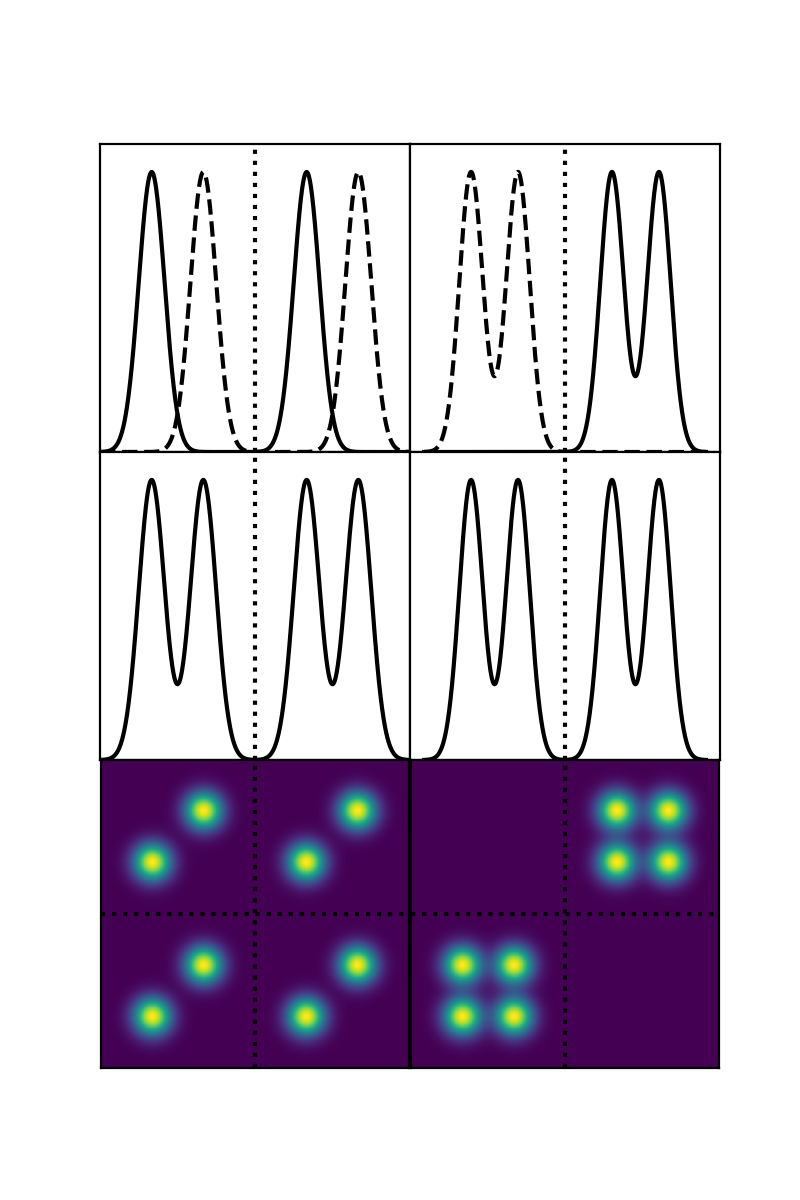

In [1380]:
xx = np.linspace(-3,3,1001,endpoint=True)
r1 = 1
r2_1 = -2
r2_2 = 2
f1 = np.exp(-0.5*(xx-r1)**2/0.25**2)
f2_1 = np.exp(-0.5*(xx-r2_1)**2/0.25**2)
f2_2 = np.exp(-0.5*(xx-r2_2)**2/0.25**2)
f1i = np.exp(-0.5*(xx+r1)**2/0.25**2)
f2_1i = np.exp(-0.5*(xx+r2_1)**2/0.25**2)
f2_2i = np.exp(-0.5*(xx+r2_2)**2/0.25**2)
ff1 = f1+f2_1
ff1i = f1i + f2_1i

ff2 = f1+f2_2
ff2i = f1i + f2_2i
plt.plot(xx,ff1)
plt.plot(xx,ff1i)
plt.show()

In [1381]:
xy = np.meshgrid(xx,xx)
ffc1=np.tile(np.array([ff1]).T,len(ff2))*np.tile(np.array([ff1]).T,len(ff1)).T
ffc1i=np.tile(np.array([ff1i]).T,len(ff1i))*np.tile(np.array([ff1i]).T,len(ff1i)).T
ffc2=np.tile(np.array([ff2]).T,len(ff2))*np.tile(np.array([ff2]).T,len(ff2)).T
ffc2i=np.tile(np.array([ff2i]).T,len(ff2i))*np.tile(np.array([ff2i]).T,len(ff2i)).T

In [1382]:
ffc1 = np.outer(ff1,ff1)
ffc1i = np.outer(ff1i,ff1i)
ffc2 = np.outer(ff2,ff2)
ffc2i = np.outer(ff2i,ff2i)

In [1775]:
fig,ax = plt.subplots(4,2,
                      gridspec_kw={"hspace":0.05,"wspace":0.05,'height_ratios': [1,1,1,1],"width_ratios":[1,1],
                                  },
                      figsize=(4.2,8.6))
a = ax[0,0]
a.plot([0,0],[0,1.1],"k:")
a.plot(xx,ff1,"b")
a.plot(xx,ff1i,"r-")
a.set_ylim([0,1.1])
a.set_xlim([-3,3])



a = ax[1,0]
a.plot(xx,ff1+ff1i,"k-")
a.plot([0,0],[0,1.1],"k:")
a.set_ylim([0,1.1])
a.set_xlim([-3,3])


a = ax[0,1]
a.plot([0,0],[0,1.1],"k:")
a.plot(xx,ff2,"b")
a.plot(xx,ff2i,"r-")
a.set_ylim([0,1.1])
a.set_xlim([-3,3])


a = ax[1,1]
a.plot(xx,ff2+ff2i,"k-")
a.plot([0,0],[0,1.1],"k:")
a.set_ylim([0,1.1])
a.set_xlim([-3,3])


a = ax[2,0]
a.imshow(-ffc1+ffc1i,origin="lower",cmap="bwr")

a.axvline(len(xx)/2,color="k",linestyle=":")
a.axhline(len(xx)/2,color="k",linestyle=":")



a = ax[2,1]
a.imshow(ffc2i-ffc2,origin="lower",cmap="bwr")
a.axvline(len(xx)/2,color="k",linestyle=":")
a.axhline(len(xx)/2,color="k",linestyle=":")


a = ax[3,0]
a.imshow(ffc1+ffc1i,origin="lower",cmap="Greys")
a.axvline(len(xx)/2,color="k",linestyle=":")
a.axhline(len(xx)/2,color="k",linestyle=":")

a = ax[3,1]
a.imshow(ffc2+ffc2i,origin="lower",cmap="Greys")
a.axvline(len(xx)/2,color="k",linestyle=":")
a.axhline(len(xx)/2,color="k",linestyle=":")

for a in ax.flatten():
    [i.set_linewidth(1) for i in a.spines.values()]
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()
    
fig.savefig("inversion_invariance.svg",bbox_inches=0)
fig.show()

/Users/albert/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


ValueError: x and y must have same first dimension, but have shapes (1000,) and (1001,)

In [2510]:
mm = np.random.randn(2)
ff = np.add.outer(mm[0]*f,mm[1]*f)

/Users/albert/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


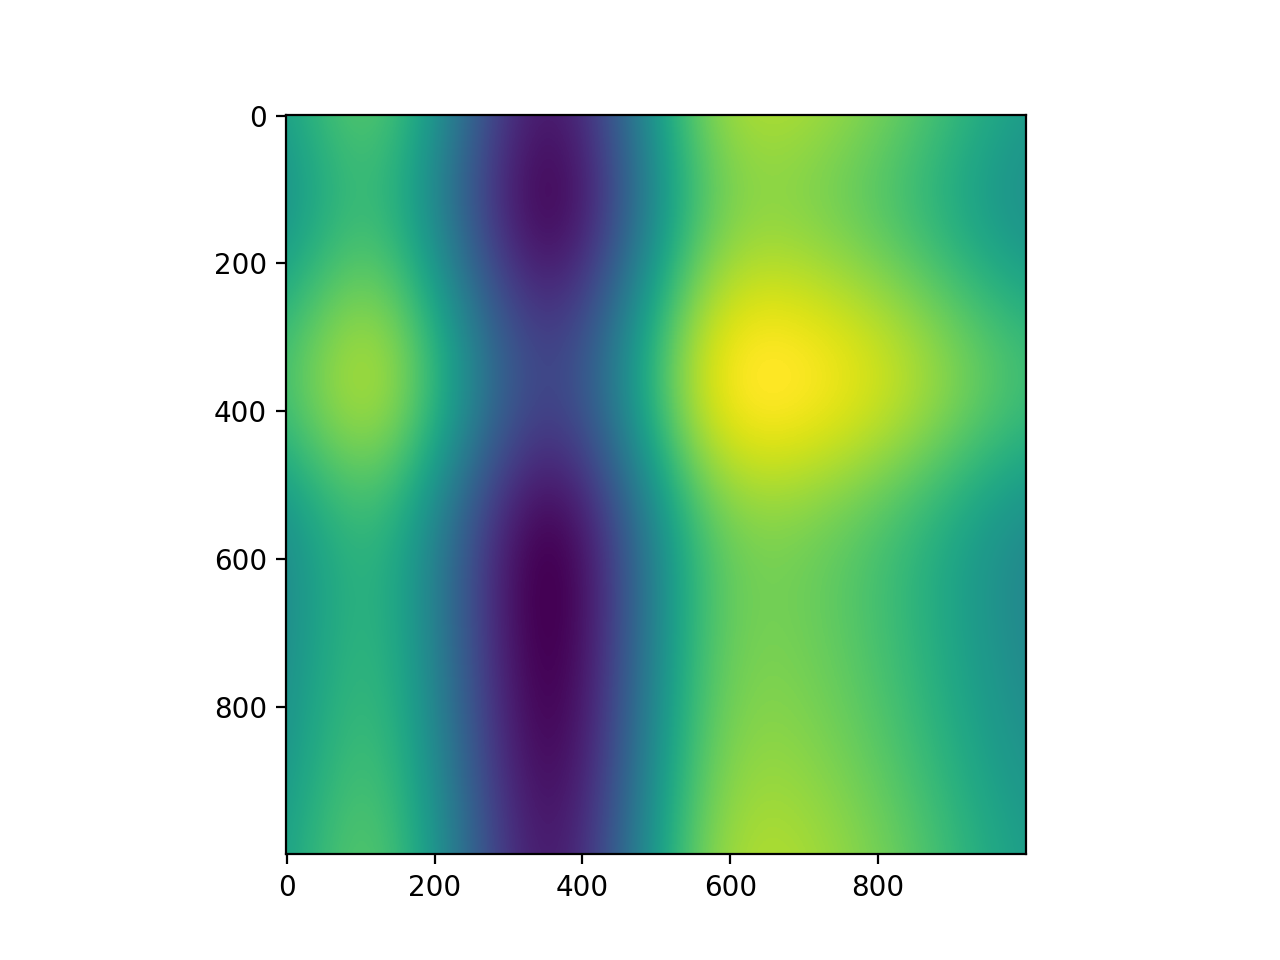

In [2511]:
plt.imshow(ff)
plt.show()